In [1]:
import matplotlib.pyplot as plt
import itertools
import hoomd
import math

import xarray as xr
import numpy
import gsd.hoomd
import sphere_fres as sf


In [2]:
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='random.gsd')

#simulation parameters
initial_kT = 0.01

In [3]:
mc = hoomd.hpmc.integrate.Sphere(default_d=2, default_a=0.2)
mc.shape['A'] = dict(diameter=7, orientable=True)
sim.operations.integrator = mc


In [4]:
patch_code = f"""

const float kT = param_array[0];

return -31000/kT;

"""


In [5]:
patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut=10,
                                                    code=patch_code,
                                                    param_array=[initial_kT])

mc.pair_potential = patch_potential
sim.run(0000)
print(patch_potential.energy)

-232500000.0


In [6]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=[
    'energy',
])
logger[('kT',)] = (lambda: patch_potential.param_array[0], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(50),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)


In [7]:
sim.run(30000)


In [8]:
gsd_writer.flush()

data = gsd.hoomd.read_log('log.gsd')
step = data['configuration/step']

beta_potential_energy = data['log/hpmc/pair/user/CPPPotential/energy']
kT = data['log/kT']
potential_energy = beta_potential_energy * kT


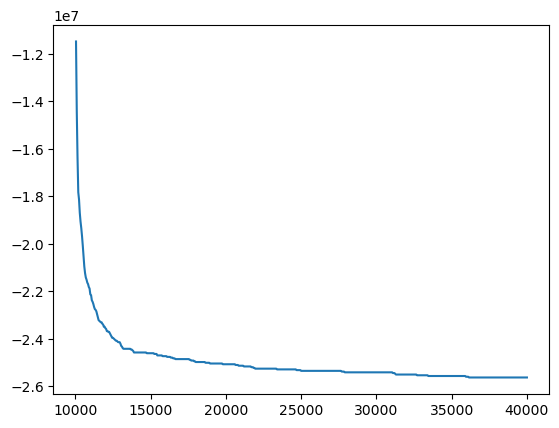

In [9]:
plt.figure(1)
plt.plot(step,potential_energy)

In [24]:
with sim.state.cpu_local_snapshot as sn:
    #print(sn.particles.position)
    N_particles = max(sn.particles.tag)
    distlog = numpy.array([])
    neighborlist = numpy.array([])
    for i in range(N_particles):
        for j in range(i+1,N_particles):
            displacement = sn.particles.position[i,:]- sn.particles.position[j,:]
            temp_dist = math.sqrt(numpy.dot(displacement, displacement))
            distlog = numpy.append(distlog,temp_dist)
            if temp_dist <= 10:
                neighborlist = numpy.append(neighborlist,[int(i),int(j)])
    dist =sn.particles.position[0,:]- sn.particles.position[1,:]
    #print(math.sqrt(numpy.dot(dist, dist)))

Text(0.5, 0, 'Distance / 10^(-10)m')

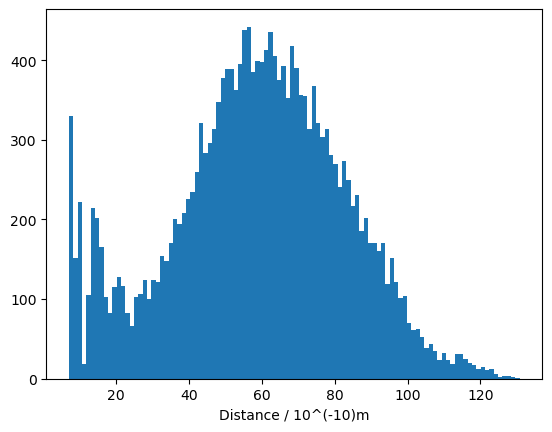

In [25]:
plt.figure(2)
plt.hist(distlog,bins=int(numpy.max(distlog)*0.8))
plt.xlabel('Distance / 10^(-10)m')

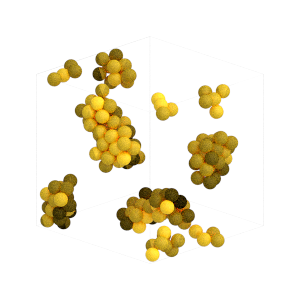

In [12]:
sf.render(sim.state.get_snapshot(),120*1.4)

In [26]:
neighborlist=numpy.reshape(neighborlist,(int(numpy.size(neighborlist)/2),2) ) 

In [27]:
neighborlist[int(numpy.size(neighborlist)/2)-1,:]

array([197., 198.])

In [28]:
with sim.state.cpu_local_snapshot as sn:
    angle_distlog = numpy.array([])
    for i in range(0,int(numpy.size(neighborlist)/2)):
        P1 = int(neighborlist[i,0])
        P2 = int(neighborlist[i,1])
        Q1 = numpy.array(sn.particles.orientation[P1,:])
        Q2 = numpy.array(sn.particles.orientation[P2,:])
        in_prod = numpy.sum(Q1*Q2)
        Angle_dist = math.acos( 2*(in_prod)**2-1)
        angle_distlog = numpy.append(angle_distlog,Angle_dist)
 

(array([  57.,  195.,  441.,  698., 1086., 1561., 1964., 2222., 2528.,
        2801., 3011., 3137.]),
 array([0.10607219, 0.35902266, 0.61197312, 0.86492359, 1.11787405,
        1.37082452, 1.62377499, 1.87672545, 2.12967592, 2.38262638,
        2.63557685, 2.88852731, 3.14147778]),
 <BarContainer object of 12 artists>)

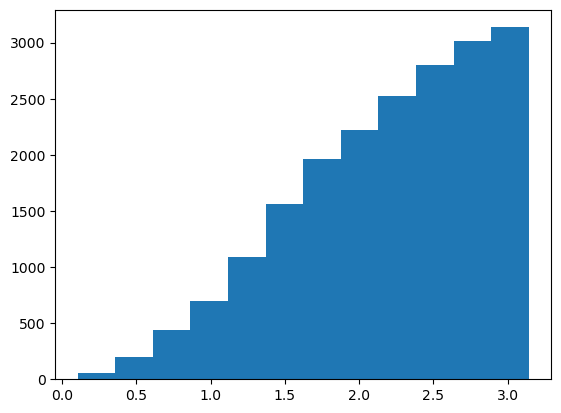

In [34]:
plt.figure(23)
plt.hist(angle_distlog,bins=12)

In [17]:
import quat_mult as qm

with sim.state.cpu_local_snapshot as sn:
    #angle_distlog = numpy.array([])
    indexlog = numpy.array([])
    for i in range(0,int(numpy.size(neighborlist)/2)):
        P1 = int(neighborlist[i,0])
        P2 = int(neighborlist[i,1])
        Q1 = numpy.array(sn.particles.orientation[P1,:])
        Q2 = numpy.array(sn.particles.orientation[P2,:])
        in_prod = numpy.sum(Q1*Q2)
        #Angle_dist = math.acos( 2*(in_prod)**2-1)
        #angle_distlog = numpy.append(angle_distlog,Angle_dist)
        
        Q1_conj = numpy.array([Q1[0], -Q1[1],-Q1[2],-Q1[3]])
        
        Q_rel = qm.quaternion_multiply(Q2,Q1_conj)
        
        angles=numpy.array([0.,1.,2.])

        sinr_cosp = 2 * (Q_rel[0] * Q_rel[1] + Q_rel[2] * Q_rel[3]);
        cosr_cosp = 1 - 2 * (Q_rel[1] * Q_rel[1] + Q_rel[2] * Q_rel[2]);
        angles[0] = math.atan2(sinr_cosp, cosr_cosp);

        sinp = math.sqrt(1 + 2 * (Q_rel[0] * Q_rel[2] - Q_rel[1] * Q_rel[3]));
        cosp = math.sqrt(1 - 2 * (Q_rel[0] * Q_rel[2] - Q_rel[1] * Q_rel[3]));
        angles[1] = 2 * math.atan2(sinp, cosp) - math.pi / 2;


        siny_cosp = 2 * (Q_rel[0] * Q_rel[3] + Q_rel[1] * Q_rel[2]);
        cosy_cosp = 1 - 2 * (Q_rel[2] * Q_rel[2] + Q_rel[3] * Q_rel[3]);
        angles[2] = math.atan2(siny_cosp, cosy_cosp);

        a=round((-abs(angles[0])/math.pi)+1);
        b=round((-(2*abs(angles[1]))/math.pi)+1) ;
        c=round((-abs(angles[2])/math.pi)+1);
        
        indexlog=numpy.append(indexlog,[a*4+b*2+c])

In [18]:
max(angle_distlog)

3.138401482700247

(array([ 51.,  55., 117., 131.,  49.,  53., 110., 137.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

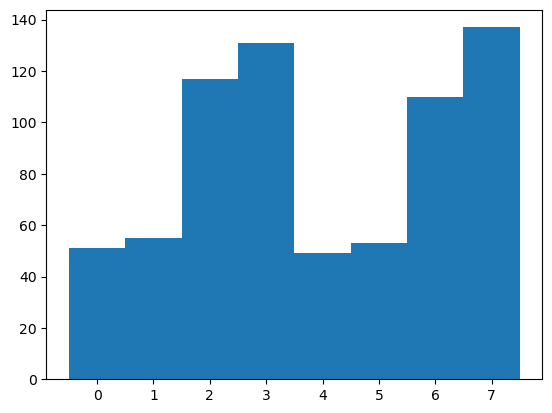

In [20]:
plt.figure(4)
plt.hist(indexlog,bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])

In [21]:
neighborlist.astype(int)

#create triplets
triplet=numpy.array([])
for i in range(int(numpy.size(neighborlist)/2)):
        for j in range(i+1,int(numpy.size(neighborlist)/2)):
            tpair1 = numpy.array(neighborlist[i,:])
            tpair2 = numpy.array(neighborlist[j,:])
            temp_triplet = numpy.unique( numpy.concatenate((tpair1,tpair2 )) )
            if numpy.size(temp_triplet) == 3:
                triplet=numpy.append(triplet, temp_triplet)

In [22]:
triplet = numpy.reshape(triplet,(int(numpy.size(triplet)/3),3) ) 
triplet = numpy.unique(triplet,axis=0) #remove double counted triplets

with sim.state.cpu_local_snapshot as sn:
    v_angle_log = numpy.array([])
    for i in range(0,int(numpy.size(triplet)/3)):
        I1 = int(triplet[i,0])
        I2 = int(triplet[i,1])
        I3 = int(triplet[i,2])
        Pos1 = numpy.array(sn.particles.position[I1,:])
        Pos2 = numpy.array(sn.particles.position[I2,:])
        Pos3 = numpy.array(sn.particles.position[I3,:])
        V1 = Pos1-Pos2
        V2 = Pos2-Pos3
        V3 = Pos3-Pos1
        sz1 = math.sqrt(abs(numpy.dot(V1,V1)))
        sz2 = math.sqrt(abs(numpy.dot(V2,V2)))
        sz3 = math.sqrt(abs(numpy.dot(V3,V3)))
        if sz1>sz2 and sz1>sz3:
            v_angle_log = numpy.append( v_angle_log , math.acos(numpy.dot(V2,V3)/(sz2*sz3)) )
        elif sz2>sz1 and sz2>sz3:
            v_angle_log = numpy.append( v_angle_log , math.acos(numpy.dot(V1,V3)/(sz1*sz3)) )
        elif sz3>sz2 and sz3>sz1:
            v_angle_log = numpy.append( v_angle_log , math.acos(numpy.dot(V1,V2)/(sz1*sz2)) )

(array([  7.,  22.,  38.,  59.,  85.,  86., 110., 109., 129., 156., 199.,
        227., 280., 258., 210., 675., 625., 589., 599., 468.]),
 array([0.01335457, 0.11724816, 0.22114175, 0.32503534, 0.42892893,
        0.53282252, 0.6367161 , 0.74060969, 0.84450328, 0.94839687,
        1.05229046, 1.15618405, 1.26007764, 1.36397123, 1.46786481,
        1.5717584 , 1.67565199, 1.77954558, 1.88343917, 1.98733276,
        2.09122635]),
 <BarContainer object of 20 artists>)

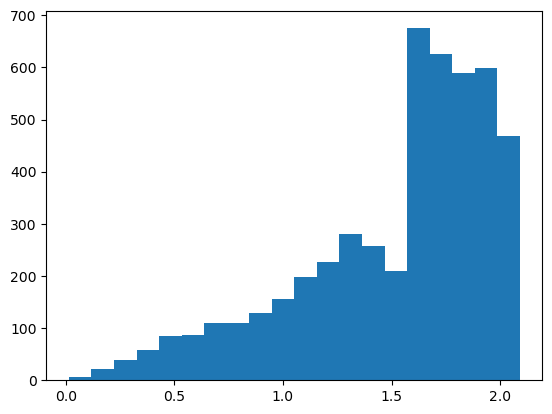

In [23]:
plt.figure(5)
plt.hist(v_angle_log,bins=20)
#Spike at 2 radians indicates equilateral triangles